## Strategy Industry Mean Reversion during earnings

This strategy only takes position during earning periods (as the debt ebitda signal)

This signal computes for each GICS industry their mean cumulative returns over the last 50 tradind days, by equi weighting returns from the industry's tickers

Then during the earnings periods, returns are time series ranked on a fast window (5 trading days) in decreasing order, as we expect them to mean revert during earnings

The signal is hedge by gics sector, where each gics sector contains several industrys

In [2]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.head()

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2008-01-02,A,2008-01-02,36.6587,36.7886,36.1089,36.2888,23.4977,1858900,NaN
2008-01-03,A,2008-01-03,36.2888,36.3388,35.8589,35.9289,23.2647,1995302,NaN
2008-01-04,A,2008-01-04,35.5690,35.8389,34.7093,34.7593,22.5073,3533080,NaN
2008-01-07,A,2008-01-07,35.3291,35.8689,35.0392,35.3291,22.8763,3505732,NaN
2008-01-08,A,2008-01-08,35.3491,35.7390,35.1392,35.2791,22.8439,4063445,NaN


In [4]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]
earnings['EarningsQuarter'] = pd.to_datetime(earnings['reportDate']).dt.to_period('Q')
earnings['IsReporting'] = 1

In [5]:
def business_days(start_date,end_date):
    dates_list = pd.date_range(start=start_date,end=end_date,freq='D')
    bd_list = [date for date in dates_list if date.weekday()< 5]
    return bd_list

def DATES_EARNINGS(data:pd.DataFrame,start:float,end:float,_days_before:int,_days_after:int):
    """
    This function compute the dates where the earnings periods happens
    
    data : pd.DataFrame with earning dates and binary feature IsReporting (1 if stock is reporting)
    start : when to start the earning period (float), ex if 5%, the function states that 
            the earning period starts when 5% of the SP500 stocks have reported
    end   : when to end the earning period (float), ex if 95%, the function states that 
            the earning period ends when 95% of the SP500 stocks have reported
    days_before and days after : int to determine pre earning periods and post earning periods
                                (not used in this signal)
    
    """
    all_earnings =data['EarningsQuarter'].dropna().unique().tolist()
    dates_earnings = pd.DataFrame(index = all_earnings,columns = ['start_pre','end_pre','start','end','start_post','end_post'])

    for earning in all_earnings:

        sample = data[data['EarningsQuarter']==earning][['IsReporting']]
        
        sample['IsReporting_%'] = sample['IsReporting'].div(sample['IsReporting'].sum())
        df = pd.DataFrame(sample.groupby(level=0)['IsReporting_%'].sum())
        tmp = (df['IsReporting_%']>start ) & (df['IsReporting_%']<end )

        try :
            dates_earnings.loc[earning,'start'] = df[tmp].index[0]
            dates_earnings.loc[earning,'end'] = df[tmp].index[-1]
            dates_earnings.loc[earning,'start_pre'] = dates_earnings.loc[earning,'start'] + BDay(-1- _days_before)
            dates_earnings.loc[earning,'end_pre'] = dates_earnings.loc[earning,'start'] + BDay(-1)
            dates_earnings.loc[earning,'start_post'] = dates_earnings.loc[earning,'end'] + BDay(1)
            dates_earnings.loc[earning,'end_post'] = dates_earnings.loc[earning,'end'] + BDay(1+_days_after)
            
        except :
            ''
    dates_earnings = dates_earnings.dropna()
    dates_earnings['dates_pre'] =   dates_earnings.apply(lambda x: business_days(x['start_pre'],x['end_pre']),axis=1)
    dates_earnings['dates_earn'] =   dates_earnings.apply(lambda x: business_days(x['start'],x['end']),axis=1)
    dates_earnings['dates_post'] =   dates_earnings.apply(lambda x: business_days(x['start_post'],x['end_post']),axis=1)
    dates_earnings['dates_earn_cumul'] = dates_earnings['dates_earn'].cumsum()

    return dates_earnings.sort_index()


In [6]:
dates_earnings = DATES_EARNINGS(earnings,0.05,0.95,10,10)
dates_earnings_all = dates_earnings['dates_earn_cumul'].iloc[-1]
dates_earnings
# start pre, end pre, start post, end post are pre earnings and post earnings season dates, they are not used to build the signal


,start_pre,end_pre,start,end,start_post,end_post,dates_pre,dates_earn,dates_post,dates_earn_cumul
1992Q2,1992-04-06 00:00:00,1992-04-20 00:00:00,1992-04-21 00:00:00,1992-06-30 00:00:00,1992-07-01 00:00:00,1992-07-15 00:00:00,"[1992-04-06 00:00:00, 1992-04-07 00:00:00, 199...","[1992-04-21 00:00:00, 1992-04-22 00:00:00, 199...","[1992-07-01 00:00:00, 1992-07-02 00:00:00, 199...","[2000-01-18 00:00:00, 2000-01-19 00:00:00, 200..."
1993Q1,1993-01-01 00:00:00,1993-01-15 00:00:00,1993-01-18 00:00:00,1993-03-31 00:00:00,1993-04-01 00:00:00,1993-04-15 00:00:00,"[1993-01-01 00:00:00, 1993-01-04 00:00:00, 199...","[1993-01-18 00:00:00, 1993-01-19 00:00:00, 199...","[1993-04-01 00:00:00, 1993-04-02 00:00:00, 199...","[2000-01-18 00:00:00, 2000-01-19 00:00:00, 200..."
1993Q2,1993-03-29 00:00:00,1993-04-12 00:00:00,1993-04-13 00:00:00,1993-06-30 00:00:00,1993-07-01 00:00:00,1993-07-15 00:00:00,"[1993-03-29 00:00:00, 1993-03-30 00:00:00, 199...","[1993-04-13 00:00:00, 1993-04-14 00:00:00, 199...","[1993-07-01 00:00:00, 1993-07-02 00:00:00, 199...","[2000-01-18 00:00:00, 2000-01-19 00:00:00, 200..."
1993Q3,1993-06-29 00:00:00,1993-07-13 00:00:00,1993-07-14 00:00:00,1993-09-30 00:00:00,1993-10-01 00:00:00,1993-10-15 00:00:00,"[1993-06-29 00:00:00, 1993-06-30 00:00:00, 199...","[1993-07-14 00:00:00, 1993-07-15 00:00:00, 199...","[1993-10-01 00:00:00, 1993-10-04 00:00:00, 199...","[2000-01-18 00:00:00, 2000-01-19 00:00:00, 200..."
1993Q4,1993-09-30 00:00:00,1993-10-14 00:00:00,1993-10-15 00:00:00,1993-12-31 00:00:00,1994-01-03 00:00:00,1994-01-17 00:00:00,"[1993-09-30 00:00:00, 1993-10-01 00:00:00, 199...","[1993-10-15 00:00:00, 1993-10-18 00:00:00, 199...","[1994-01-03 00:00:00, 1994-01-04 00:00:00, 199...","[2000-01-18 00:00:00, 2000-01-19 00:00:00, 200..."
...,...,...,...,...,...,...,...,...,...,...
2022Q3,2022-07-06 00:00:00,2022-07-20 00:00:00,2022-07-21 00:00:00,2022-08-04 00:00:00,2022-08-05 00:00:00,2022-08-19 00:00:00,"[2022-07-06 00:00:00, 2022-07-07 00:00:00, 202...","[2022-07-21 00:00:00, 2022-07-22 00:00:00, 202...","[2022-08-05 00:00:00, 2022-08-08 00:00:00, 202...","[2000-01-18 00:00:00, 2000-01-19 00:00:00, 200..."
2022Q4,2022-10-10 00:00:00,2022-10-24 00:00:00,2022-10-25 00:00:00,2022-11-03 00:00:00,2022-11-04 00:00:00,2022-11-18 00:00:00,"[2022-10-10 00:00:00, 2022-10-11 00:00:00, 202...","[2022-10-25 00:00:00, 2022-10-26 00:00:00, 202...","[2022-11-04 00:00:00, 2022-11-07 00:00:00, 202...","[2000-01-18 00:00:00, 2000-01-19 00:00:00, 200..."
2023Q1,2023-01-10 00:00:00,2023-01-24 00:00:00,2023-01-25 00:00:00,2023-02-23 00:00:00,2023-02-24 00:00:00,2023-03-10 00:00:00,"[2023-01-10 00:00:00, 2023-01-11 00:00:00, 202...","[2023-01-25 00:00:00, 2023-01-26 00:00:00, 202...","[2023-02-24 00:00:00, 2023-02-27 00:00:00, 202...","[2000-01-18 00:00:00, 2000-01-19 00:00:00, 200..."
2023Q2,2023-04-11 00:00:00,2023-04-25 00:00:00,2023-04-26 00:00:00,2023-05-09 00:00:00,2023-05-10 00:00:00,2023-05-24 00:00:00,"[2023-04-11 00:00:00, 2023-04-12 00:00:00, 202...","[2023-04-26 00:00:00, 2023-04-27 00:00:00, 202...","[2023-05-10 00:00:00, 2023-05-11 00:00:00, 202...","[2000-01-18 00:00:00, 2000-01-19 00:00:00, 200..."


In [10]:
GICS_ = GICS.copy()
R_ind = pd.DataFrame().reindex_like(P)

results = {}
for ind in tqdm(GICS_['gicind'].unique().tolist()):
    tickers = GICS_[GICS_['gicind']==ind].index.tolist()
    R_center = R[P].sub(R[P].rolling(50).mean(1),0)[tickers].sum(1).rolling(50).sum()
    results[ind] = R_center
    for ticker in tickers:
        R_ind[ticker] = R_center



100%|██████████| 68/68 [00:15<00:00,  4.34it/s]


Sharpe on trading days        2.4
Sharpe all backtest period    1.0
Average daily turnover (%)    1.2
Average Daily PNL (bp)        3.7
dtype: float64

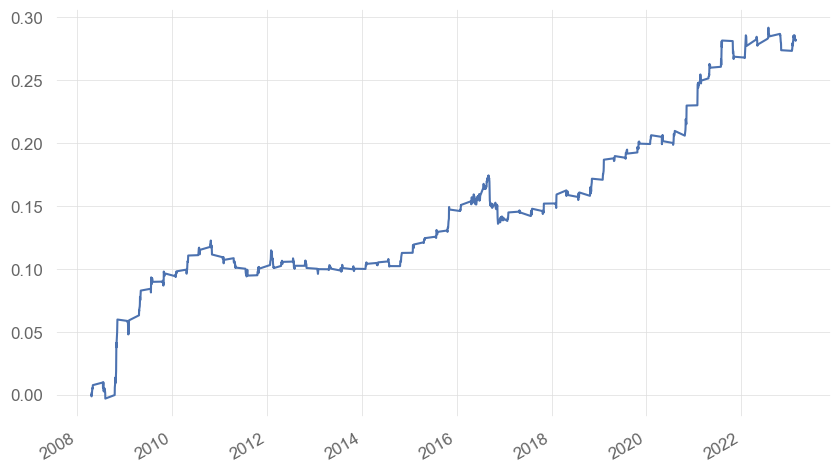

In [11]:
dates_earn = dates_earnings['dates_earn'].cumsum().iloc[-1] ## selecting earning dates
signal = R_ind[P].rolling(5).rank(pct=True,ascending=False) ## time series rank in decreasing order
signal = signal[P]
signal = signal[signal.index.isin(dates_earn)]
signal[~signal.index.isin(dates_earn)] = None ## playing only during earnings season
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf) ## cross sectionnal rank

signal = signal.groupby(GICS['gicsect'],axis=1).apply(center) ## hedge by gics sector
signal = signal[P].div(signal[P].abs().sum(1),0)

# shift signal and compute pnl
PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
PNL_all = (signal[P].shift()*R).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe on trading days':sr,
           'Sharpe all backtest period': sharpe(PNL_all),
           'Average daily turnover (%)':turnover,
           'Average Daily PNL (bp)':PNL.mean()*1e4}).round(1)

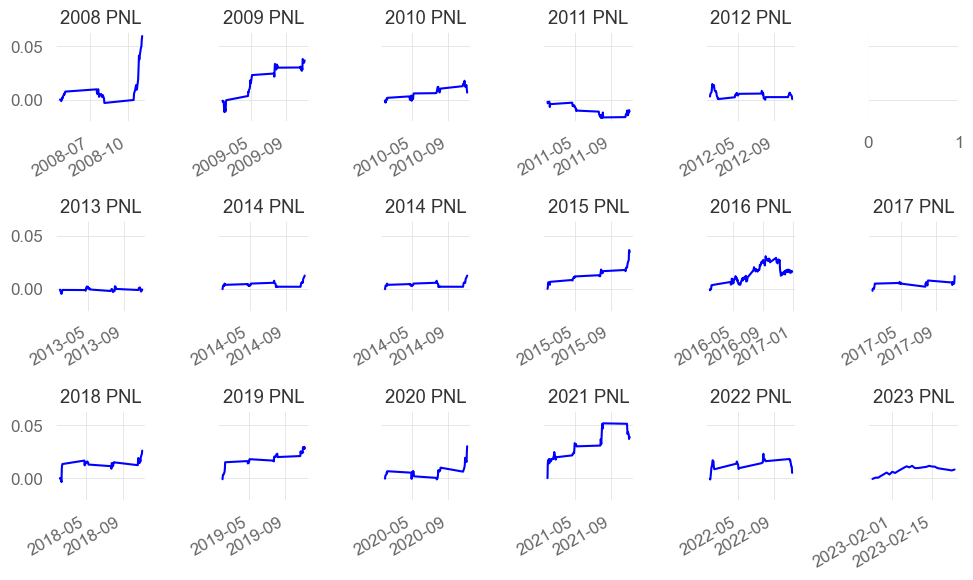

In [66]:
import matplotlib.dates as mdates
PNL_year = PNL.groupby(PNL.index.year).expanding().sum()
fig,axes = plt.subplots(nrows = 3, ncols = 6, sharey =True,sharex= False,figsize = (10,6))

for i,year in enumerate([2008,2009,2010,2011,2012]):
    subset_pnl = PNL.loc[str(year)].cumsum()
    subset_pnl.plot(ax= axes[0,i], color = 'blue')
    axes[0,i].set_title(str(year) + ' PNL')
    axes[0,i].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=4))

for i,year in enumerate([ 2013,2014,2014,2015, 2016,2017]):
    subset_pnl = PNL.loc[str(year)].cumsum()
    subset_pnl.plot(ax= axes[1,i], color = 'blue')
    axes[1,i].set_title(str(year) + ' PNL')
    axes[1,i].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=4))

for i,year in enumerate([ 2018,2019,2020, 2021,2022,2023]):
    subset_pnl = PNL.loc[str(year)].cumsum()
    subset_pnl.plot(ax= axes[2,i], color = 'blue')
    axes[2,i].set_title(str(year) + ' PNL')
    axes[2,i].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=4))

fig.tight_layout()
                        

In [13]:
PNL.to_csv('data/US/strat_industry_pnl.csv')